# IA Training — Feature Encoding & Similarity Benchmark

Ce notebook encode toutes les images de `casting_data/` avec le même pipeline ResNet50 + StandardScaler utilisé par le backend, puis benchmark plusieurs métriques de distance pour trouver la meilleure recherche de similarité.

In [1]:
import sys
print(f"Python version: {sys.version}")
assert sys.version_info[:2] == (3, 12), f"Expected Python 3.12, got {sys.version_info[:2]}"

# Install exact same versions as backend Dockerfile
!pip install --no-cache-dir torch==2.9.0+cpu torchvision==0.24.0+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install --no-cache-dir scikit-learn==1.6.1 scipy joblib numpy"<2" Pillow matplotlib

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 MB 208.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 267.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 131.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 173.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 209.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.8/930.8 kB 224.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 197.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 58.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.0/35.0 MB 101.6 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 118.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import sys, os
import torch
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision import transforms
from joblib import load
import json
import time

# Add backend to path so we can import FeatureExtractor
sys.path.insert(0, os.path.join(os.getcwd(), 'backend'))
from feature_extractor import FeatureExtractor

# --- Configuration ---
CASTING_DATA_DIR = Path('casting_data')
MODELS_DIR = Path('models')
RESNET_WEIGHTS = MODELS_DIR / 'resnet50_extractor.pth'
SCALER_PATH = MODELS_DIR / 'scaler.joblib'
OUTPUT_NPZ = MODELS_DIR / 'features_dataset.npz'
OUTPUT_CONFIG = MODELS_DIR / 'similarity_config.json'
IMG_SIZE = 224
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Device: {DEVICE}')
print(f'Casting data dir: {CASTING_DATA_DIR} (exists={CASTING_DATA_DIR.exists()})')
print(f'ResNet weights: {RESNET_WEIGHTS} (exists={RESNET_WEIGHTS.exists()})')
print(f'Scaler: {SCALER_PATH} (exists={SCALER_PATH.exists()})')

Device: cpu
Casting data dir: casting_data (exists=True)
ResNet weights: models/resnet50_extractor.pth (exists=True)
Scaler: models/scaler.joblib (exists=True)


## 1. Chargement du modèle et du scaler

In [3]:
# Load feature extractor (same as backend)
extractor = FeatureExtractor(model_name='resnet50', weights_path=str(RESNET_WEIGHTS))
extractor = extractor.to(DEVICE)
extractor.eval()
print(f'FeatureExtractor loaded on {DEVICE}')

# Load scaler (same as backend)
scaler = load(SCALER_PATH)
print(f'Scaler loaded: {type(scaler).__name__}')

# Same transform as backend (test_transform)
test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

FeatureExtractor loaded on cpu
Scaler loaded: StandardScaler


## 2. Collecte et encodage de toutes les images

In [4]:
def collect_images(base_dir: Path):
    """Recursively collect all image paths and infer labels from directory names."""
    images = []
    for img_path in sorted(base_dir.rglob('*.jpeg')):
        # Infer label from parent directory name
        parent = img_path.parent.name
        if 'ok' in parent:
            label = 'ok'
        elif 'def' in parent:
            label = 'def'
        else:
            label = 'unknown'
        # Store relative path from casting_data/
        rel_path = str(img_path.relative_to(base_dir))
        images.append((img_path, rel_path, label))
    
    # Also check for .jpg and .png
    for ext in ['*.jpg', '*.png']:
        for img_path in sorted(base_dir.rglob(ext)):
            parent = img_path.parent.name
            if 'ok' in parent:
                label = 'ok'
            elif 'def' in parent:
                label = 'def'
            else:
                label = 'unknown'
            rel_path = str(img_path.relative_to(base_dir))
            images.append((img_path, rel_path, label))
    
    return images

all_images = collect_images(CASTING_DATA_DIR)
print(f'Total images found: {len(all_images)}')

# Count by label
from collections import Counter
label_counts = Counter(label for _, _, label in all_images)
print(f'Labels: {dict(label_counts)}')

# Show first few
for _, rel, label in all_images[:5]:
    print(f'  {label:4s} | {rel}')

Total images found: 914
Labels: {'def': 652, 'ok': 262}
  def  | test/def_front/cast_def_0_1059.jpeg
  def  | test/def_front/cast_def_0_1063.jpeg
  def  | test/def_front/cast_def_0_108.jpeg
  def  | test/def_front/cast_def_0_1096.jpeg
  def  | test/def_front/cast_def_0_112.jpeg


In [5]:
def encode_images(image_list, extractor, scaler, transform, device, batch_size=32):
    """Encode all images through ResNet50 + Scaler. Returns features matrix."""
    all_features = []
    all_paths = []
    all_labels = []
    errors = []
    
    total = len(image_list)
    t0 = time.time()
    
    # Process in batches for efficiency
    for i in range(0, total, batch_size):
        batch = image_list[i:i+batch_size]
        batch_tensors = []
        batch_paths = []
        batch_labels = []
        
        for img_path, rel_path, label in batch:
            try:
                img = Image.open(img_path).convert('RGB')
                tensor = transform(img)
                batch_tensors.append(tensor)
                batch_paths.append(rel_path)
                batch_labels.append(label)
            except Exception as e:
                errors.append((rel_path, str(e)))
        
        if not batch_tensors:
            continue
        
        # Stack into batch tensor
        batch_tensor = torch.stack(batch_tensors).to(device)
        
        # Extract features
        with torch.no_grad():
            features = extractor(batch_tensor).cpu().numpy()
        
        # Scale features
        features_scaled = scaler.transform(features)
        
        all_features.append(features_scaled)
        all_paths.extend(batch_paths)
        all_labels.extend(batch_labels)
        
        # Progress
        done = min(i + batch_size, total)
        elapsed = time.time() - t0
        print(f'\r  Encoded {done}/{total} images ({elapsed:.1f}s)', end='', flush=True)
    
    print(f'\nDone! {len(all_paths)} images encoded in {time.time()-t0:.1f}s')
    if errors:
        print(f'  ⚠️ {len(errors)} errors: {errors[:3]}')
    
    features_matrix = np.vstack(all_features)
    return features_matrix, np.array(all_paths), np.array(all_labels)

features, paths, labels = encode_images(
    all_images, extractor, scaler, test_transform, DEVICE
)
print(f'\nFeatures shape: {features.shape}')
print(f'Paths: {paths.shape}, Labels: {labels.shape}')

  Encoded 914/914 images (17.5s)
Done! 914 images encoded in 17.5s

Features shape: (914, 2048)
Paths: (914,), Labels: (914,)


In [6]:
# Save to .npz
np.savez(
    OUTPUT_NPZ,
    features=features,
    paths=paths,
    labels=labels,
)
file_size_mb = OUTPUT_NPZ.stat().st_size / (1024 * 1024)
print(f'Saved: {OUTPUT_NPZ} ({file_size_mb:.1f} MB)')
print(f'  features: {features.shape} ({features.dtype})')
print(f'  paths: {paths.shape}')
print(f'  labels: {labels.shape}')

Saved: models/features_dataset.npz (7.3 MB)
  features: (914, 2048) (float32)
  paths: (914,)
  labels: (914,)


## 3. Benchmark des métriques de distance

On compare plusieurs métriques pour trouver la plus pertinente pour la recherche de similarité visuelle.

In [7]:
from scipy.spatial.distance import cdist, cosine, euclidean, cityblock, minkowski
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Reload if needed
data = np.load(OUTPUT_NPZ, allow_pickle=True)
features = data['features']
paths = data['paths']
labels = data['labels']
print(f'Loaded {features.shape[0]} feature vectors of dim {features.shape[1]}')

# Define distance functions
METRICS = {
    'euclidean': lambda q, db: cdist(q.reshape(1, -1), db, metric='euclidean').flatten(),
    'cosine': lambda q, db: cdist(q.reshape(1, -1), db, metric='cosine').flatten(),
    'manhattan': lambda q, db: cdist(q.reshape(1, -1), db, metric='cityblock').flatten(),
    'minkowski_p3': lambda q, db: cdist(q.reshape(1, -1), db, metric='minkowski', p=3).flatten(),
    'correlation': lambda q, db: cdist(q.reshape(1, -1), db, metric='correlation').flatten(),
    'chebyshev': lambda q, db: cdist(q.reshape(1, -1), db, metric='chebyshev').flatten(),
}

def get_top_k(query_idx, metric_fn, features, k=10):
    """Get top-k most similar images for a query (excluding itself)."""
    query = features[query_idx]
    distances = metric_fn(query, features)
    # Exclude the query itself
    distances[query_idx] = np.inf
    top_indices = np.argsort(distances)[:k]
    top_distances = distances[top_indices]
    return top_indices, top_distances

print('Metrics defined:', list(METRICS.keys()))

Loaded 914 feature vectors of dim 2048
Metrics defined: ['euclidean', 'cosine', 'manhattan', 'minkowski_p3', 'correlation', 'chebyshev']



Query: test/def_front/cast_def_0_669.jpeg (label=def)


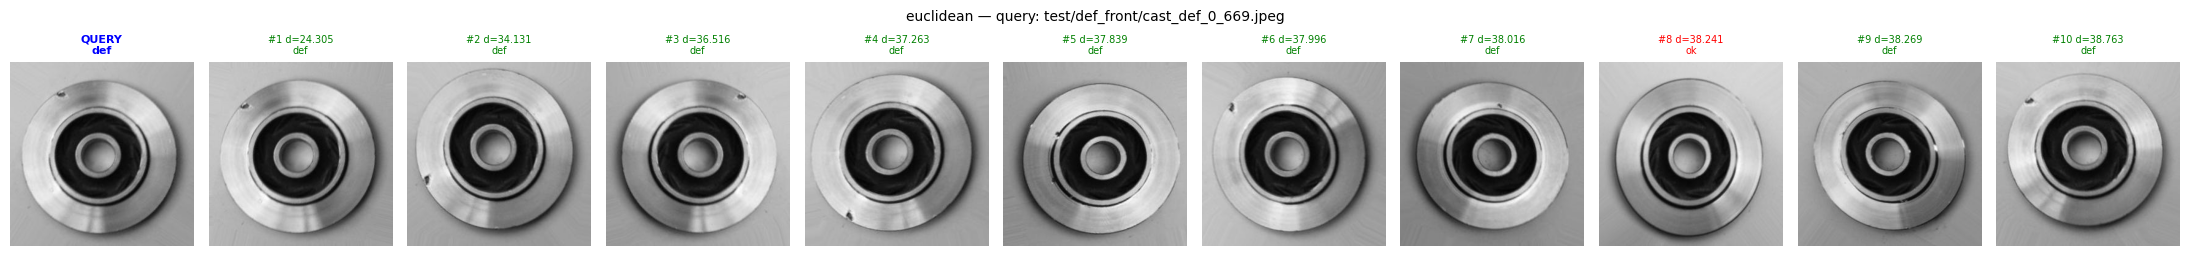

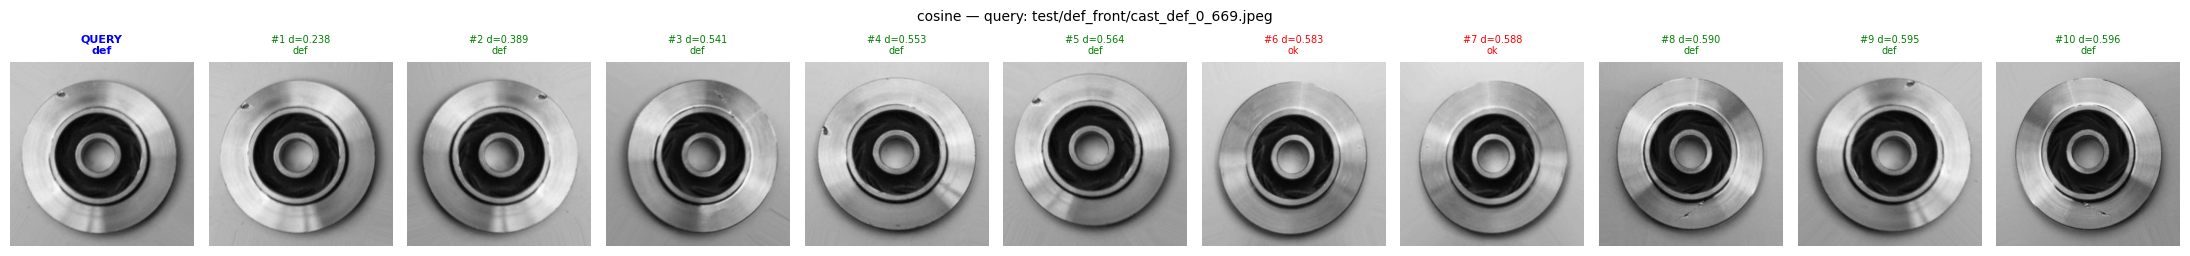

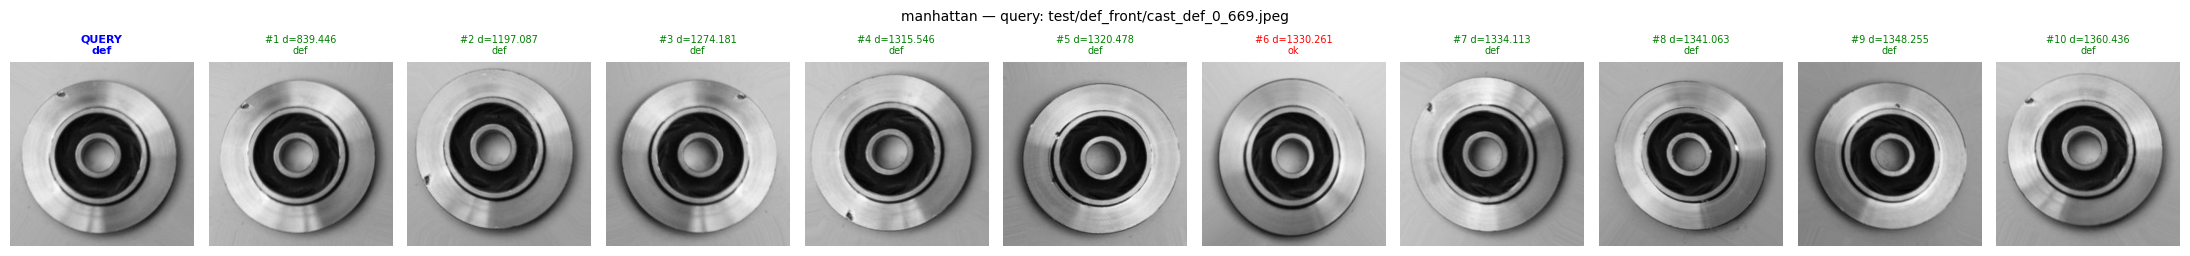

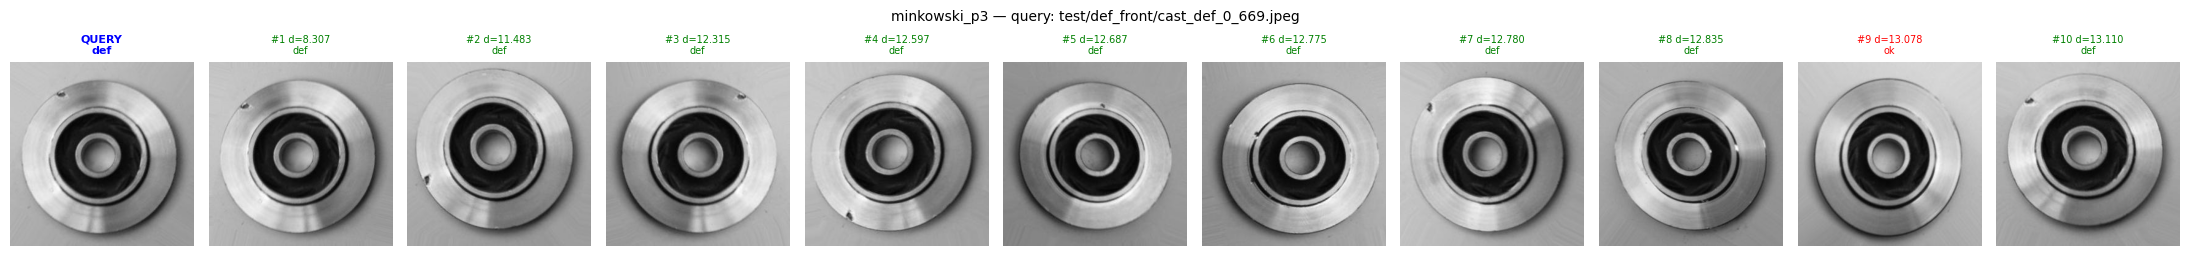

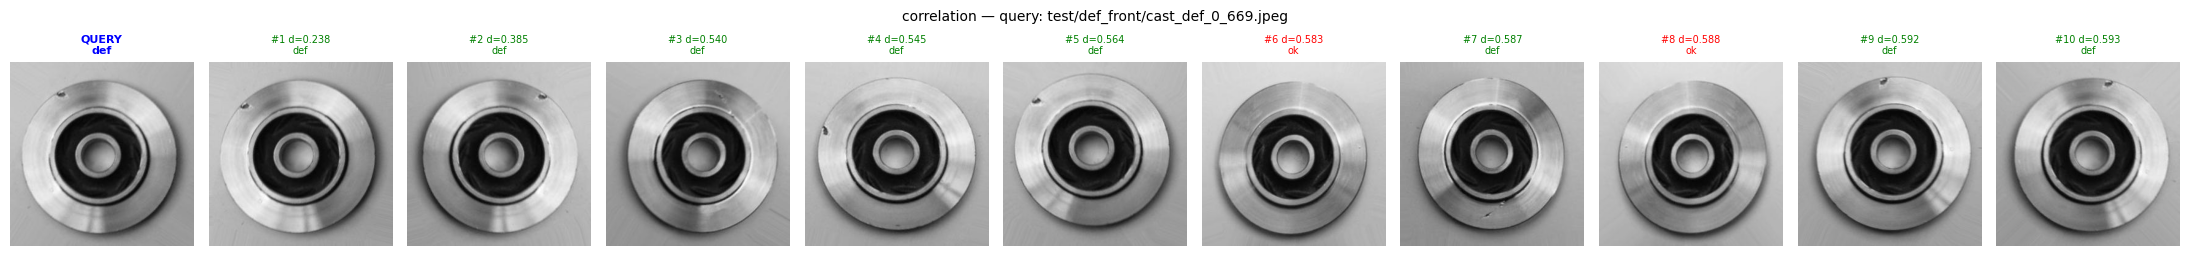

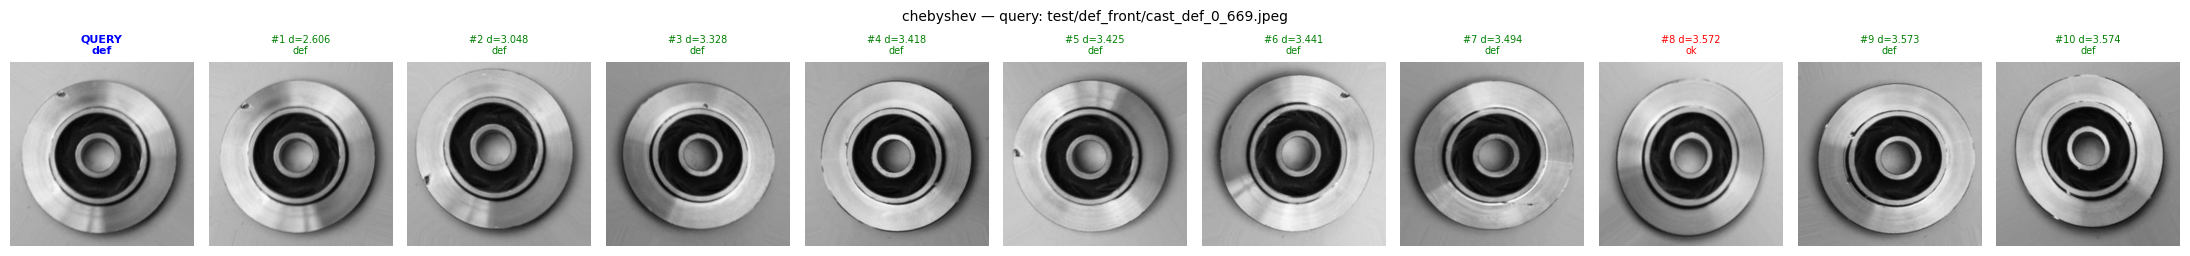


Query: train/def_front/cast_def_0_5413.jpeg (label=def)


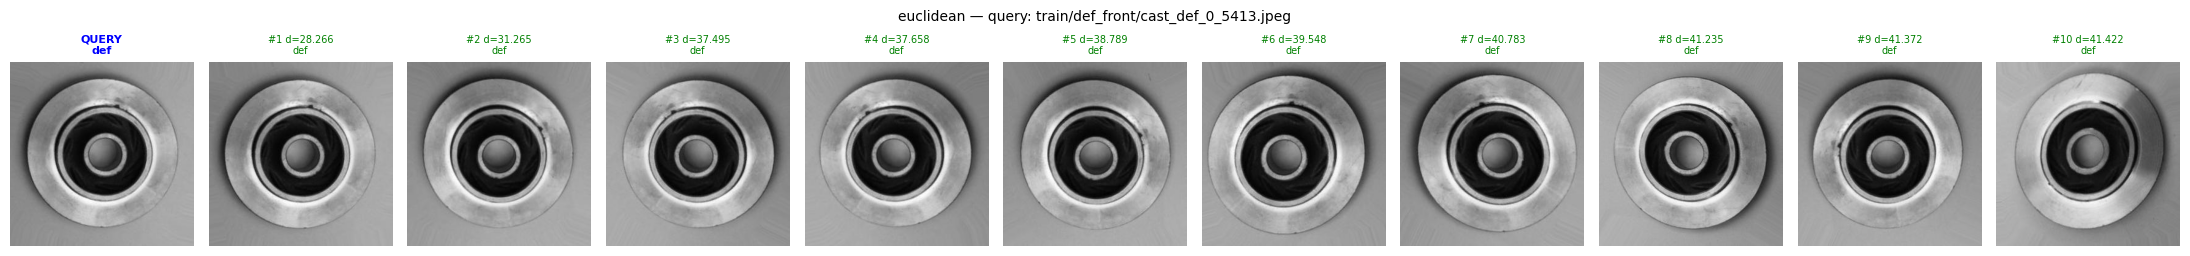

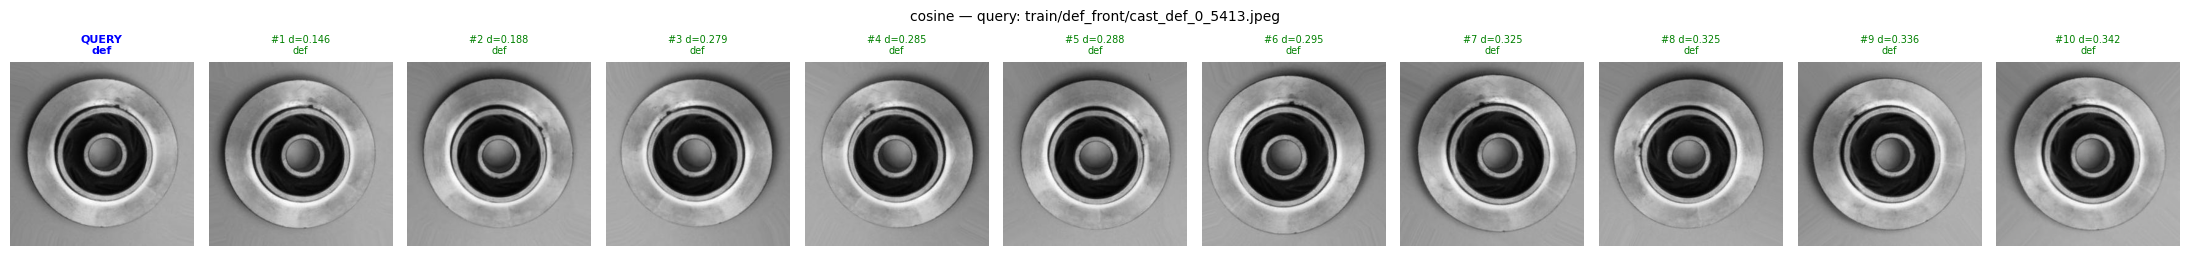

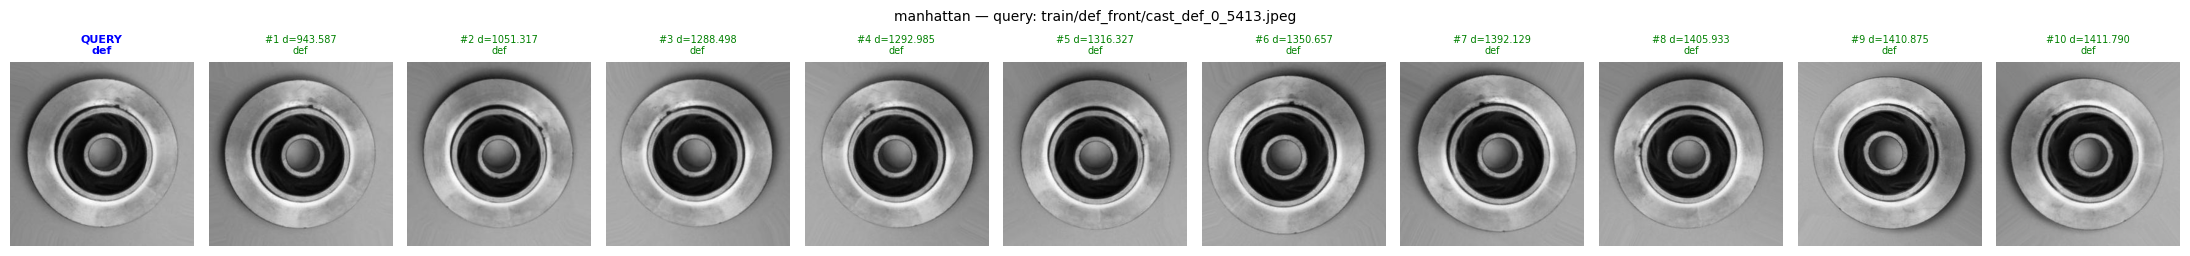

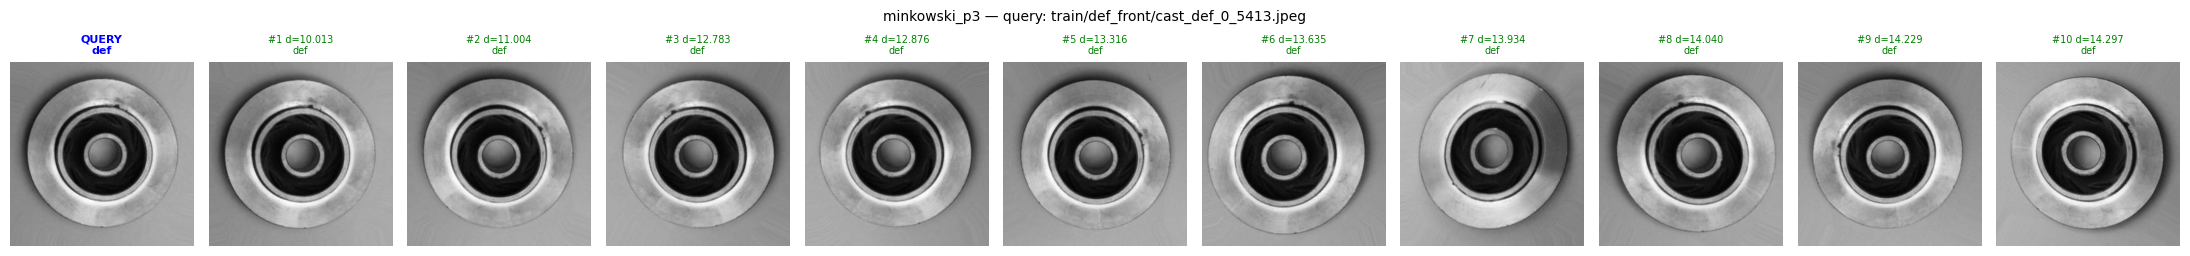

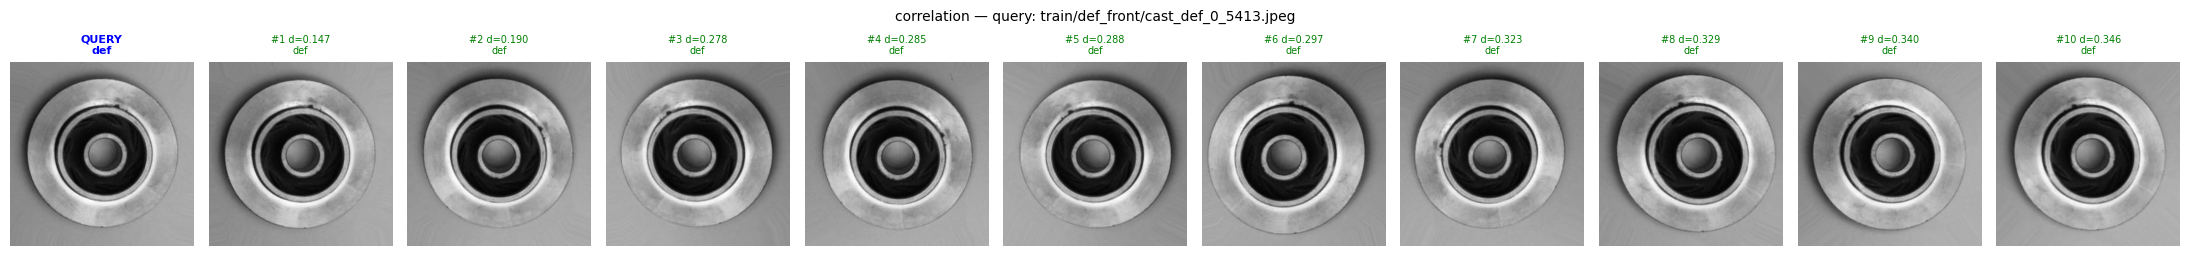

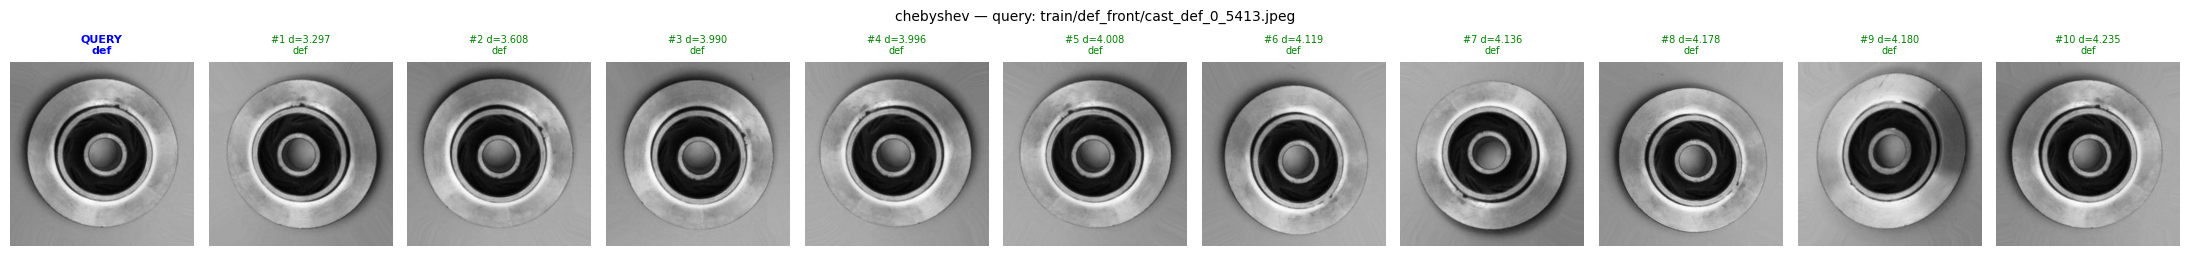


Query: test/def_front/cast_def_0_591.jpeg (label=def)


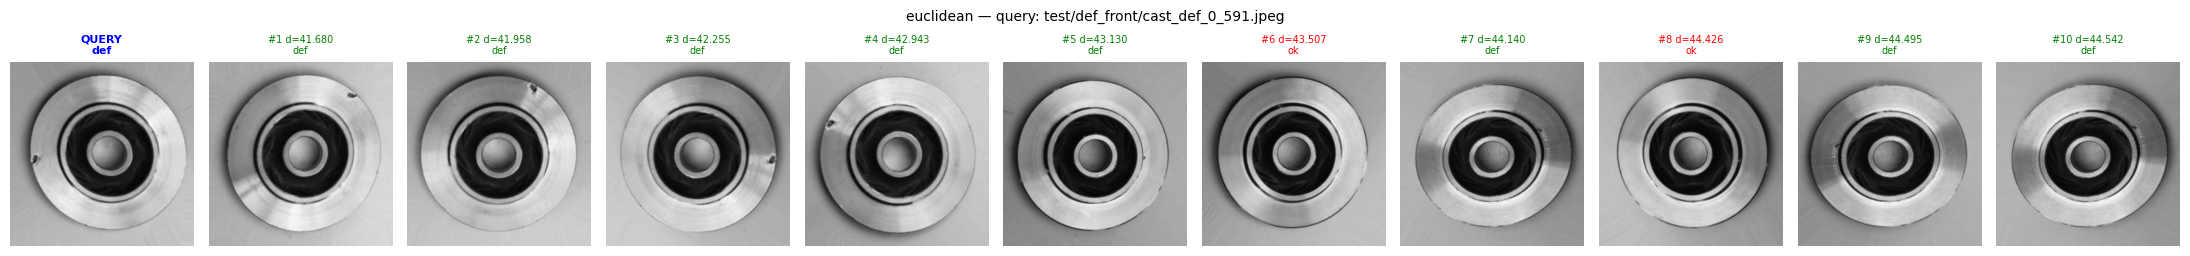

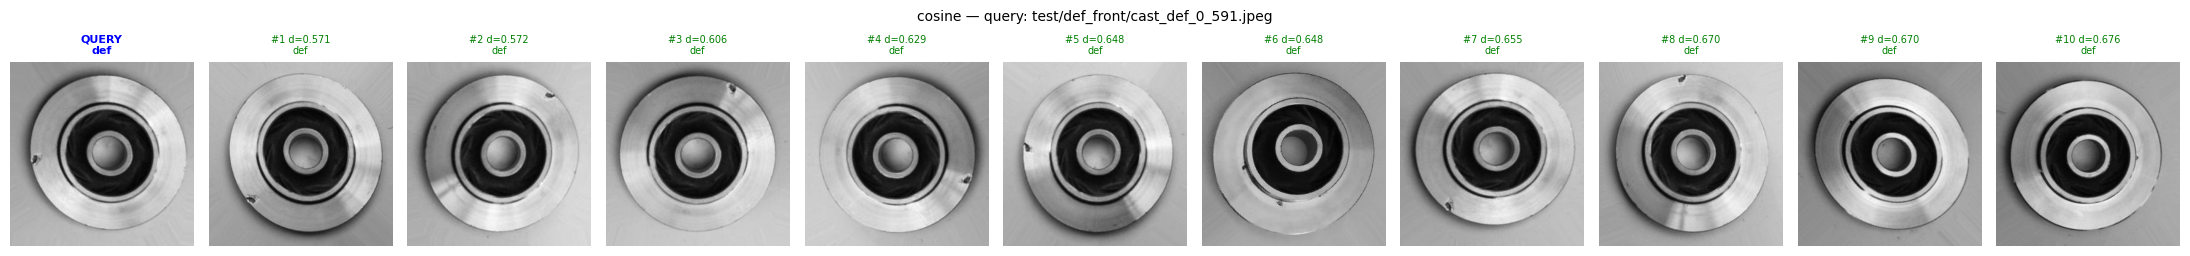

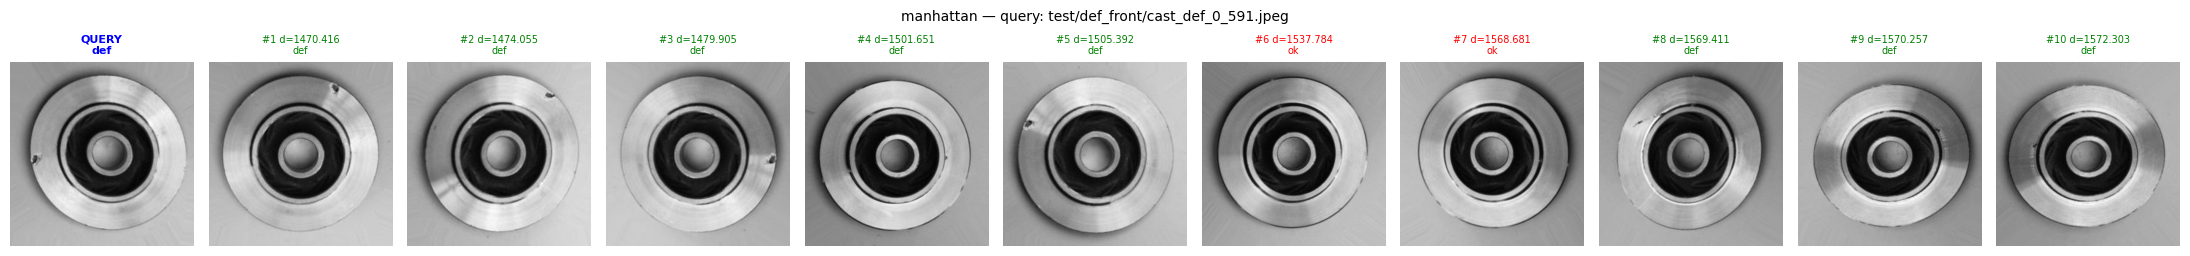

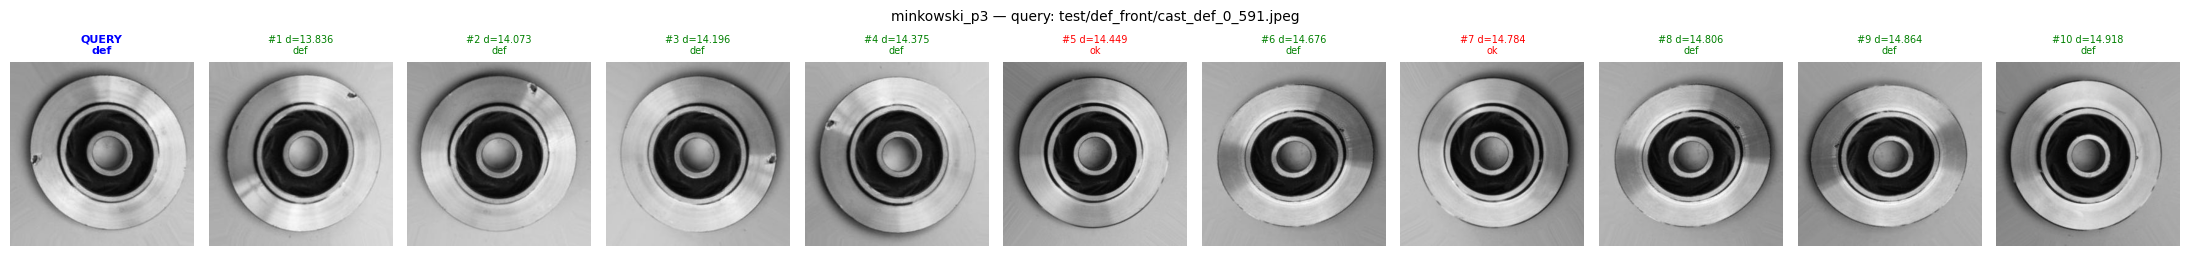

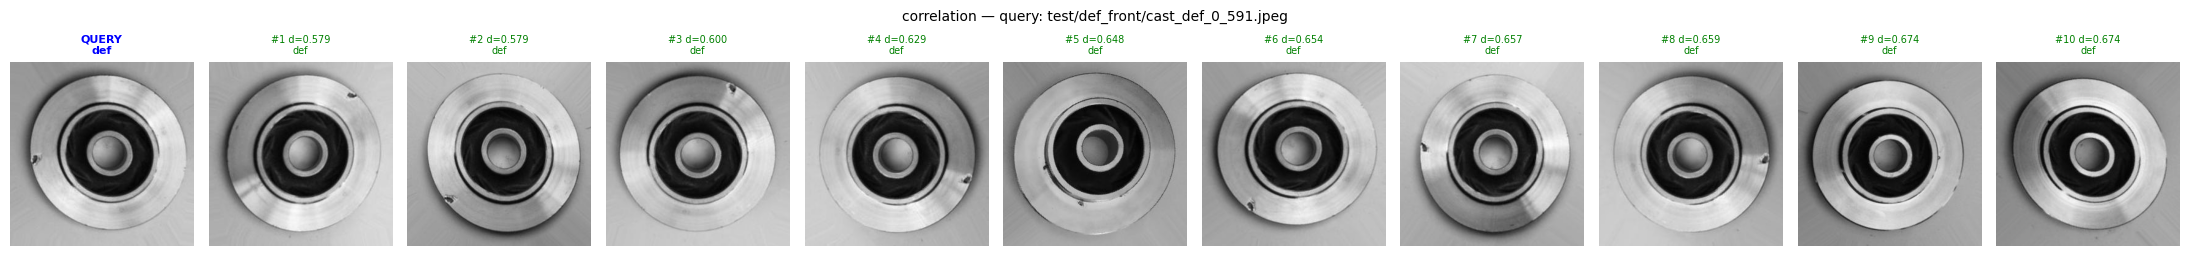

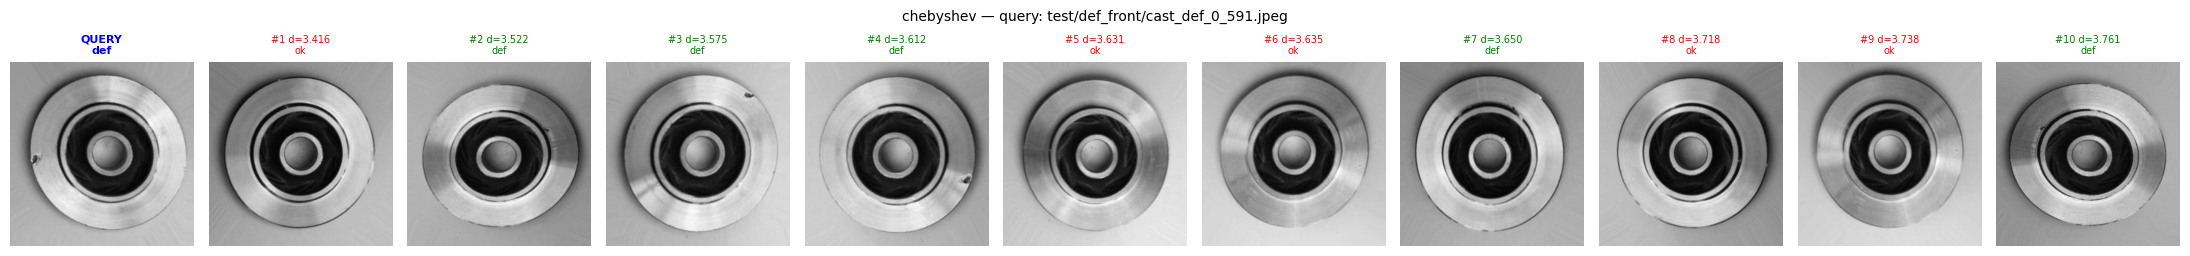

In [8]:
# Visual benchmark: pick random query images and show top-10 for each metric
np.random.seed(42)
sample_indices = np.random.choice(len(features), size=3, replace=False)

for q_idx in sample_indices:
    q_path = paths[q_idx]
    q_label = labels[q_idx]
    print(f'\n{"="*80}')
    print(f'Query: {q_path} (label={q_label})')
    print(f'{"="*80}')
    
    for metric_name, metric_fn in METRICS.items():
        top_idx, top_dist = get_top_k(q_idx, metric_fn, features, k=10)
        
        # Show results as grid
        fig, axes = plt.subplots(1, 11, figsize=(22, 2.5))
        fig.suptitle(f'{metric_name} — query: {q_path}', fontsize=10, y=1.02)
        
        # Query image
        q_img = Image.open(CASTING_DATA_DIR / q_path)
        axes[0].imshow(q_img)
        axes[0].set_title(f'QUERY\n{q_label}', fontsize=8, fontweight='bold', color='blue')
        axes[0].axis('off')
        axes[0].spines[:].set_visible(False)
        
        # Top 10
        for i, (idx, dist) in enumerate(zip(top_idx, top_dist)):
            img = Image.open(CASTING_DATA_DIR / paths[idx])
            axes[i+1].imshow(img)
            match_color = 'green' if labels[idx] == q_label else 'red'
            axes[i+1].set_title(f'#{i+1} d={dist:.3f}\n{labels[idx]}', fontsize=7, color=match_color)
            axes[i+1].axis('off')
        
        plt.tight_layout()
        plt.show()

## 4. Évaluation quantitative

Pour chaque métrique, on mesure :
- **Same-class ratio** : % d'images du top-10 qui sont de la même classe que la requête
- **Mean distance** : distance moyenne du top-10
- **Temps de calcul** par requête

On évalue sur un échantillon de N requêtes aléatoires.

In [9]:
# Quantitative evaluation
np.random.seed(123)
N_EVAL = min(100, len(features))  # Number of query images for evaluation
eval_indices = np.random.choice(len(features), size=N_EVAL, replace=False)

results = {}

for metric_name, metric_fn in METRICS.items():
    same_class_ratios = []
    mean_distances = []
    t0 = time.time()
    
    for q_idx in eval_indices:
        top_idx, top_dist = get_top_k(q_idx, metric_fn, features, k=10)
        # Same-class ratio
        q_label = labels[q_idx]
        same_class = np.sum(labels[top_idx] == q_label)
        same_class_ratios.append(same_class / 10.0)
        mean_distances.append(np.mean(top_dist))
    
    elapsed = (time.time() - t0) / N_EVAL * 1000  # ms per query
    
    results[metric_name] = {
        'same_class_ratio': np.mean(same_class_ratios),
        'same_class_std': np.std(same_class_ratios),
        'mean_distance': np.mean(mean_distances),
        'ms_per_query': elapsed,
    }
    
    print(f'{metric_name:20s} | same-class: {results[metric_name]["same_class_ratio"]*100:.1f}% '
          f'(±{results[metric_name]["same_class_std"]*100:.1f}%) | '
          f'mean dist: {results[metric_name]["mean_distance"]:.4f} | '
          f'{elapsed:.2f} ms/query')

euclidean            | same-class: 93.1% (±14.9%) | mean dist: 42.8730 | 0.90 ms/query
cosine               | same-class: 93.0% (±17.1%) | mean dist: 0.4155 | 1.89 ms/query
manhattan            | same-class: 93.1% (±15.5%) | mean dist: 1476.4575 | 1.21 ms/query
minkowski_p3         | same-class: 92.2% (±15.4%) | mean dist: 14.7059 | 22.41 ms/query
correlation          | same-class: 93.5% (±16.1%) | mean dist: 0.4157 | 3.92 ms/query
chebyshev            | same-class: 82.7% (±17.4%) | mean dist: 4.3129 | 1.56 ms/query


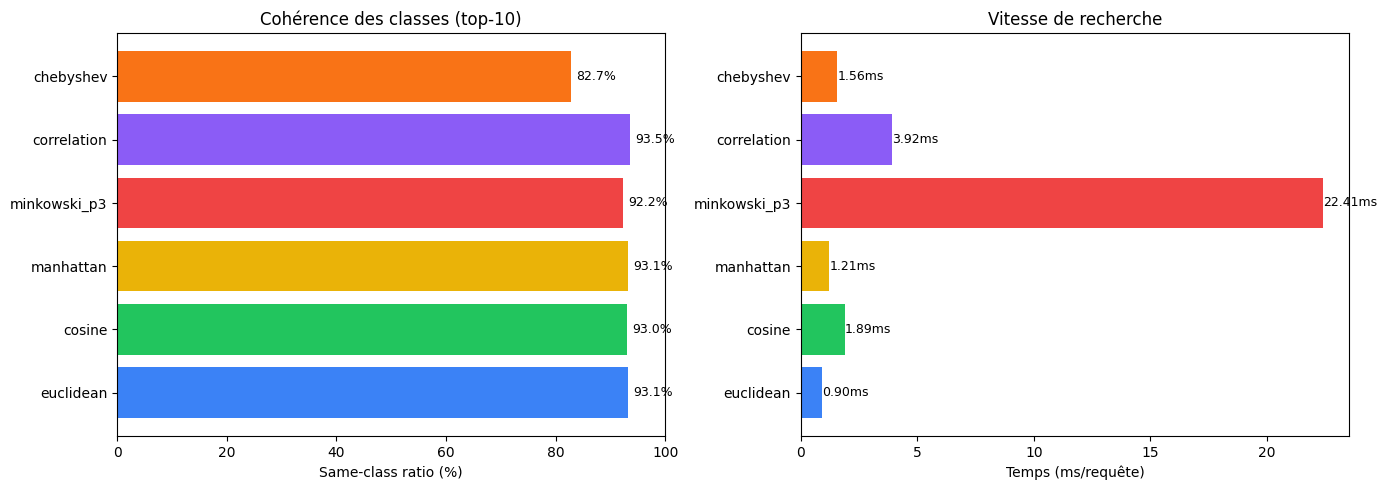

In [10]:
# Summary chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

metric_names = list(results.keys())
same_class_vals = [results[m]['same_class_ratio'] * 100 for m in metric_names]
time_vals = [results[m]['ms_per_query'] for m in metric_names]

colors = ['#3b82f6', '#22c55e', '#eab308', '#ef4444', '#8b5cf6', '#f97316']

ax1.barh(metric_names, same_class_vals, color=colors[:len(metric_names)])
ax1.set_xlabel('Same-class ratio (%)')
ax1.set_title('Cohérence des classes (top-10)')
ax1.set_xlim(0, 100)
for i, v in enumerate(same_class_vals):
    ax1.text(v + 1, i, f'{v:.1f}%', va='center', fontsize=9)

ax2.barh(metric_names, time_vals, color=colors[:len(metric_names)])
ax2.set_xlabel('Temps (ms/requête)')
ax2.set_title('Vitesse de recherche')
for i, v in enumerate(time_vals):
    ax2.text(v + 0.01, i, f'{v:.2f}ms', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 5. Combinaisons de distances

In [11]:
# Test weighted combinations of distance metrics
def normalize_distances(distances):
    """Min-max normalize distances to [0, 1]."""
    dmin, dmax = distances.min(), distances.max()
    if dmax - dmin < 1e-10:
        return np.zeros_like(distances)
    return (distances - dmin) / (dmax - dmin)

COMBOS = {
    'cosine+euclidean_50_50': {'cosine': 0.5, 'euclidean': 0.5},
    'cosine+euclidean_70_30': {'cosine': 0.7, 'euclidean': 0.3},
    'cosine+manhattan_60_40': {'cosine': 0.6, 'manhattan': 0.4},
    'cosine+correlation_50_50': {'cosine': 0.5, 'correlation': 0.5},
}

def combo_distance(query, db, weights_dict):
    """Compute weighted combination of normalized distances."""
    combined = np.zeros(db.shape[0])
    for metric_name, weight in weights_dict.items():
        raw = METRICS[metric_name](query, db)
        combined += weight * normalize_distances(raw)
    return combined

# Evaluate combinations
print('\n--- Combined Metrics ---')
combo_results = {}

for combo_name, weights in COMBOS.items():
    same_class_ratios = []
    t0 = time.time()
    
    for q_idx in eval_indices:
        query = features[q_idx]
        distances = combo_distance(query, features, weights)
        distances[q_idx] = np.inf
        top_idx = np.argsort(distances)[:10]
        same_class = np.sum(labels[top_idx] == labels[q_idx])
        same_class_ratios.append(same_class / 10.0)
    
    elapsed = (time.time() - t0) / N_EVAL * 1000
    combo_results[combo_name] = {
        'same_class_ratio': np.mean(same_class_ratios),
        'same_class_std': np.std(same_class_ratios),
        'ms_per_query': elapsed,
        'weights': weights,
    }
    
    print(f'{combo_name:35s} | same-class: {np.mean(same_class_ratios)*100:.1f}% | {elapsed:.2f} ms/query')


--- Combined Metrics ---
cosine+euclidean_50_50              | same-class: 92.8% | 3.10 ms/query
cosine+euclidean_70_30              | same-class: 92.8% | 2.72 ms/query
cosine+manhattan_60_40              | same-class: 92.8% | 2.99 ms/query
cosine+correlation_50_50            | same-class: 93.1% | 6.05 ms/query


## 6. Sauvegarde de la configuration finale

Après analyse des résultats ci-dessus, modifiez la cellule ci-dessous pour choisir la métrique optimale.

In [12]:
# =====================================================
# CHOOSE THE BEST METRIC HERE based on results above
# =====================================================

# Find best single metric
best_single = max(results.items(), key=lambda x: x[1]['same_class_ratio'])
print(f'Best single metric: {best_single[0]} ({best_single[1]["same_class_ratio"]*100:.1f}%)')

# Find best combo
if combo_results:
    best_combo = max(combo_results.items(), key=lambda x: x[1]['same_class_ratio'])
    print(f'Best combination: {best_combo[0]} ({best_combo[1]["same_class_ratio"]*100:.1f}%)')
else:
    best_combo = None

# Compare and choose
if best_combo and best_combo[1]['same_class_ratio'] > best_single[1]['same_class_ratio'] + 0.01:
    # Use combined metric
    config = {
        'type': 'combined',
        'name': best_combo[0],
        'weights': best_combo[1]['weights'],
        'same_class_ratio': round(best_combo[1]['same_class_ratio'], 4),
        'ms_per_query': round(best_combo[1]['ms_per_query'], 3),
    }
else:
    # Use single metric
    config = {
        'type': 'single',
        'name': best_single[0],
        'metric': best_single[0],
        'same_class_ratio': round(best_single[1]['same_class_ratio'], 4),
        'ms_per_query': round(best_single[1]['ms_per_query'], 3),
    }

print(f'\nChosen config:')
print(json.dumps(config, indent=2))

# Save
with open(OUTPUT_CONFIG, 'w') as f:
    json.dump(config, f, indent=2)

print(f'\n✅ Config saved to {OUTPUT_CONFIG}')

Best single metric: correlation (93.5%)
Best combination: cosine+correlation_50_50 (93.1%)

Chosen config:
{
  "type": "single",
  "name": "correlation",
  "metric": "correlation",
  "same_class_ratio": 0.935,
  "ms_per_query": 3.919
}

✅ Config saved to models/similarity_config.json
